In [ ]:
#Importing Libraries
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
import matplotlib.pyplot as plt


 Structuration des données pour entraîner un modèle de reconnaissance visuelle de produits cosmétiques.

In [ ]:
base_path = '/content/drive/MyDrive/image/'

3. Analyse des Données :
* Vérification de la répartition des images par catégorie (ex : 930 images pour "Fragrance"), cruciale pour identifier les déséquilibres de classes.



* Utilisation de os.listdir pour compter les fichiers dans chaque dossier.

Affichage des statistiques pour valider la qualité des données.

In [ ]:
count = 0
dirs = os.listdir(base_path)
for dir in dirs:
    files = list(os.listdir(os.path.join(base_path, dir)))
    print(f"{dir} Folder has {len(files)} Images")
    count += len(files)
print(f"\nImages Folder has {count} Images in total")


Skincare Folder has 50 Images
Bodycare Folder has 349 Images
Makeup Folder has 44 Images
Fragrance Folder has 930 Images
Haircare Folder has 529 Images

Images Folder has 1902 Images in total


Définition du chemin des images (base_path).

Paramétrage de la taille des images (img_size=180) et du lot (batch=32), optimisés pour la mémoire et la vitesse.

In [ ]:
base_dir = '/content/drive/MyDrive/image/'
img_size = 180
batch = 32

4. Création des Jeux de Données
* Préparation des données pour l’entraînement et la validation, avec une répartition 80-20.

* image_dataset_from_directory de TensorFlow pour charger les images et les redimensionner automatiquement.

Séparation des données en entraînement (train_ds) et validation (val_ds).

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'training',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

val_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'validation',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

Found 1902 files belonging to 5 classes.
Using 1522 files for training.
Found 1902 files belonging to 5 classes.
Using 380 files for validation.


In [ ]:
Product_names = train_ds.class_names
Product_names

['Bodycare', 'Fragrance', 'Haircare', 'Makeup', 'Skincare']

5. Visualisation des Images
* Vérification visuelle des étiquettes et de la cohérence des données.

* Utilisation de matplotlib pour afficher 9 images avec leurs étiquettes.

Confirmation que les images sont correctement chargées et étiquetées.

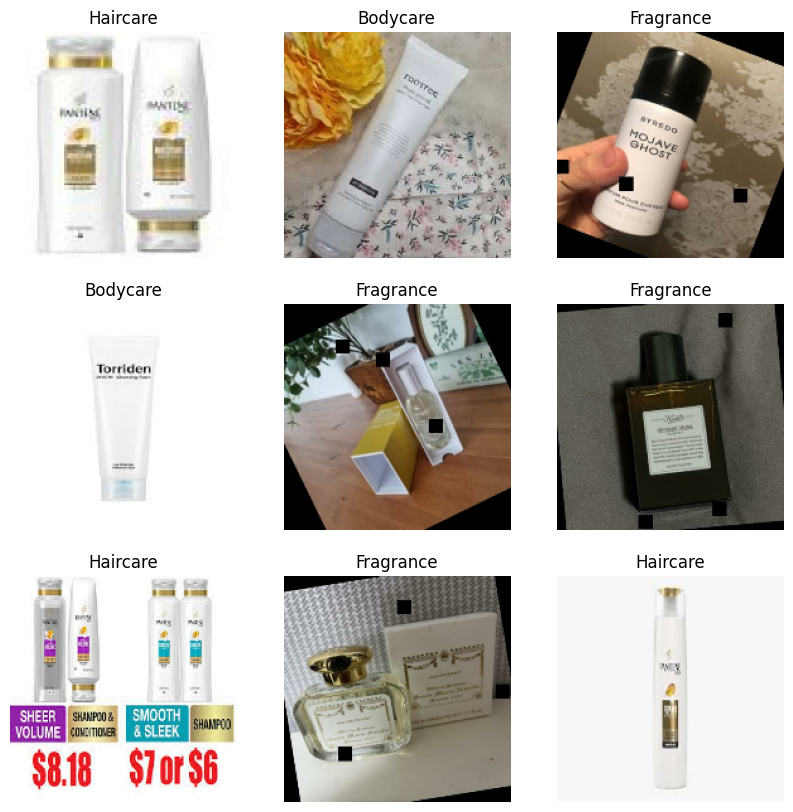

In [ ]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(Product_names[labels[i]])
        plt.axis('off')

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [ ]:
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [ ]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_size,img_size,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


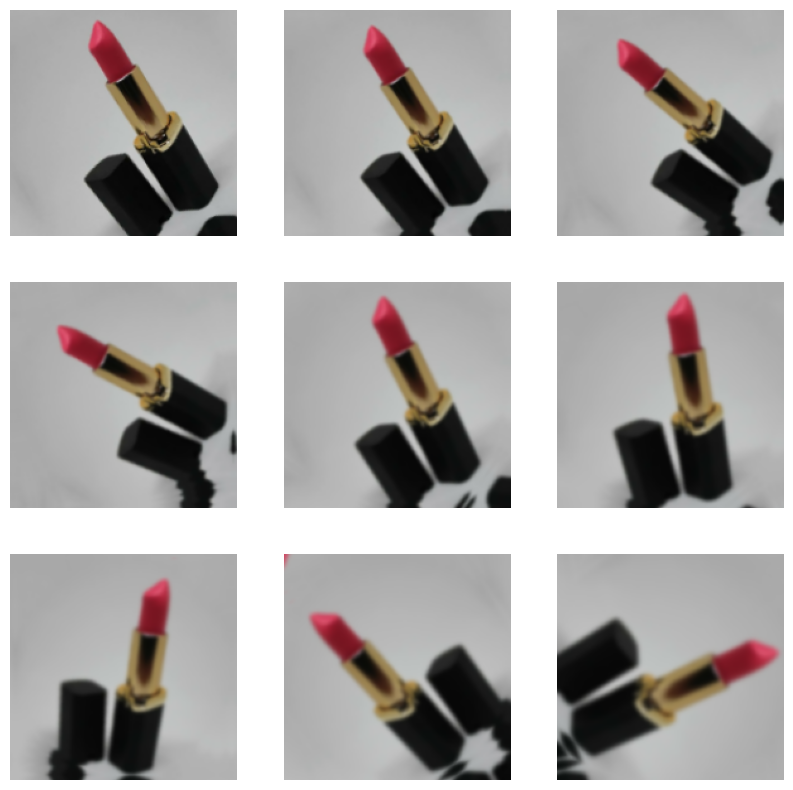

In [ ]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

#MOdel Creation

6. Construction du Modèle CNN
*  Création d’un modèle de deep learning pour classer automatiquement les produits cosmétiques.

* Architecture séquentielle avec couches de convolution (Conv2D), pooling (MaxPooling2D), et régularisation (Dropout).

Fonction de perte sparse_categorical_crossentropy adaptée aux classes multiples.

Optimiseur Adam pour une convergence rapide.

In [ ]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 154s 3s/step - accuracy: 0.4633 - loss: 1.2831 - val_accuracy: 0.8053 - val_loss: 0.6065
Epoch 2/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.6753 - loss: 0.8098 - val_accuracy: 0.8158 - val_loss: 0.5702
Epoch 3/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.7592 - loss: 0.6509 - val_accuracy: 0.8368 - val_loss: 0.4868
Epoch 4/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7660 - loss: 0.6289 - val_accuracy: 0.8474 - val_loss: 0.4760
Epoch 5/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.8059 - loss: 0.5186 - val_accuracy: 0.8316 - val_loss: 0.4914
Epoch 6/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.8145 - loss: 0.5137 - val_accuracy: 0.8395 - val_loss: 0.4964
Epoch 7/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.8326 - loss: 0.4370 - val_accuracy: 0.8421 - val_loss: 0.5139
Epoch 8/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.8673 - loss: 0.3710 - val_accuracy: 0.8553 - val_los

In [ ]:
def classify_images(image_path):
    input_image = tf.keras.utils.load_img(image_path, target_size=(180,180))
    input_image_array = tf.keras.utils.img_to_array(input_image)
    input_image_exp_dim = tf.expand_dims(input_image_array,0)

    predictions = model.predict(input_image_exp_dim)
    result = tf.nn.softmax(predictions[0])
    outcome = 'The Image belongs to ' + Product_names[np.argmax(result)] + ' with a score of '+ str(np.max(result)*100)
    return outcome

In [ ]:
classify_images('/content/drive/MyDrive/image/Bodycare/-9-_jpeg.rf.e68955726779608af75bf3cd136c8063.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


'The Image belongs to Bodycare with a score of 99.147766'

In [ ]:
model.save('Cosmetic_Recog_Model.h5')

In [ ]:
# prompt: install streamlit

!pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.9 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import numpy as np
from keras.models import load_model
from google.colab import files
from PIL import Image
import io

# Affichage d'un titre (optionnel dans Colab)
print(" Flower Classification CNN Model ")
flower_names = ['Bodycare', 'Fragrance', 'Haircare', 'Makeup', 'Skincare']

# Charger le modèle
model = load_model('Cosmetic_Recog_Model.h5')

# Fonction de classification
def classify_images(image):
    image = image.resize((180, 180))
    image_array = tf.keras.utils.img_to_array(image)
    image_exp_dim = tf.expand_dims(image_array, 0)

    predictions = model.predict(image_exp_dim)
    result = tf.nn.softmax(predictions[0])
    outcome = 'The image belongs to **' + flower_names[np.argmax(result)] + '** with a score of ' + str(round(np.max(result)*100, 2)) + '%'
    return outcome

# Téléversement du fichier
uploaded = files.upload()  # Cela ouvre une fenêtre pour uploader l'image depuis votre machine

# Traitement du fichier uploadé
for fn in uploaded.keys():
    image = Image.open(io.BytesIO(uploaded[fn]))
    display(image)  # Affiche l’image uploadée
    result = classify_images(image)
    print(result)


 Flower Classification CNN Model 


Saving images.jpg to images (2).jpg
